In [1]:
%matplotlib inline

In [2]:
import os
import glob

import matplotlib
import pandas

import n10ioana.parse

In [3]:
INPUT_DIR = "run.perlmutter.iops"
RUN_KEY = {
    "randio.1": "-F",
    "randio.2": "-F -C",
    "randio.3": "-F -C -e",
    "randio.4": "-F -C -e\n--posix.directio",
}

In [4]:


results = None
for file in glob.glob(os.path.join(INPUT_DIR, "randio.?")):
    parsed = n10ioana.parse.IorOutput(open(file, "r"))
    df = pandas.DataFrame.from_records(parsed["results"])
    df["filename"] = os.path.basename(file)
    df["key"] = df["filename"].map(lambda x: RUN_KEY.get(x, "unknown"))
    if results is None:
        results = df
    else:
        results = pandas.concat((results, df))

In [5]:
results.sort_values("filename")

,access,bw(mib/s),iops,latency(s),block(kib),xfer(kib),open(s),wr/rd(s),close(s),total(s),iter,filename,key
0,write,13974.00,3593043,0.000628,1024.0,4.0,0.004842,0.291835,0.142488,0.293126,0,randio.1,-F
1,read,144684.00,37349128,0.000073,1024.0,4.0,0.000509,0.028075,0.010210,0.028310,0,randio.1,-F
0,write,13038.00,3341871,0.000583,1024.0,4.0,0.003385,0.313769,0.164446,0.314166,0,randio.2,-F -C
1,read,225.43,57710,0.059070,1024.0,4.0,0.000594,18.170000,4.000000,18.170000,0,randio.2,-F -C
0,write,10863.00,2784846,0.000632,1024.0,4.0,0.003620,0.376529,0.221960,0.377059,0,randio.3,-F -C -e
1,read,229.36,58717,0.066062,1024.0,4.0,0.000630,17.860000,3.260000,17.860000,0,randio.3,-F -C -e
0,write,417.30,106838,0.032809,1024.0,4.0,0.003866,9.810000,2.160000,9.820000,0,randio.4,-F -C -e\n--posix.directio
1,read,1513.00,387370,0.010366,1024.0,4.0,0.000618,2.710000,1.150000,2.710000,0,randio.4,-F -C -e\n--posix.directio


In [6]:
data_table = results.pivot(index="key", columns="access", values="bw(mib/s)") / 1000
data_table = data_table[["write", "read"]]
data_table.columns = ["Write", "Read"]

0 -F 13.974 144.684
1 -F -C 13.038 0.22543000000000002
2 -F -C -e 10.863 0.22936
3 -F -C -e
--posix.directio 0.4173 1.513


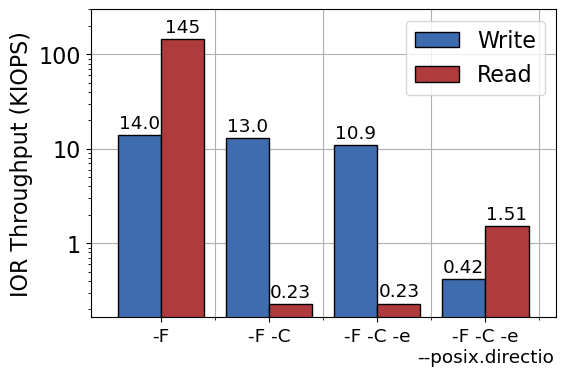

In [7]:
BIN_WIDTH = 0.80

ax = data_table.plot.bar(
    width=BIN_WIDTH,
    edgecolor='black',
    color=["#3F6CAF", "#B03B3D"])
ax.set_yscale("log")
ax.set_axisbelow(True)
ax.yaxis.grid(True, which="major")
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))
ax.set_ylabel("IOR Throughput (KIOPS)")

legend = ax.get_legend()
legend.set_title(None)

ax.set_ylim(None, 300)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize="small")

ax.xaxis.grid(True, which="minor")
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([x + 0.5 for x in range(len(data_table))]))

ax.set_xlabel("")

for i, (idx, (a, b)) in enumerate(data_table.iterrows()):
    print(i, idx, a, b)
    for j, x in enumerate([a, b]):
        if x < 10.0:
            fmt_str = "{:.2f}"
        elif x < 100.0:
            fmt_str = "{:.1f}"
        else:
            fmt_str = "{:.0f}"
        ax.annotate(
            fmt_str.format(x),
            xy=(i - 0.25 * BIN_WIDTH if not j else i + 0.25 * BIN_WIDTH, x),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            fontsize="small")
        
fig = ax.get_figure()
fig.savefig("iops-vs-cache.pdf", bbox_inches='tight', transparent=True)

In [8]:
data_table

,Write,Read
key,,
-F,13.9740,144.68400
-F -C,13.0380,0.22543
-F -C -e,10.8630,0.22936
-F -C -e\n--posix.directio,0.4173,1.51300
